<a href="https://colab.research.google.com/github/Rysekk/MNIST-100labels/blob/main/Deep_Learning_projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Processing

In [1]:
#implementation
%matplotlib inline
import os
import sys 
import datetime
import tensorboard
import numpy as np
import tensorflow as tf
import tensorboard
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential,Model
from keras.layers import Dense, Conv2D, Flatten,LeakyReLU,Dropout,Activation,Reshape,Conv2DTranspose,Input,Lambda,BatchNormalization
from keras.datasets import mnist
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
import gc
from keras import backend #utiliser pour mettre un fonction d'activation que l'on doit implementer 
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.models import load_model
from keras.datasets.mnist import load_data
import numpy as np
from matplotlib import pyplot

In [2]:
# Fonction d'activation fournis dans le papier 
def activation_focntion(x):
    logexpsum = backend.sum(backend.exp(x), axis=-1, keepdims=True)
    result = logexpsum / (logexpsum + 1.0)
    return result

In [3]:
def discriminator(in_shape=(28,28,1), n_classes=10):
    
    # image input
    discriminateur = Sequential()
    # downsample
    discriminateur.add(Conv2D(128, (3,3), strides=(2,2),input_shape=in_shape, padding='same'))
    discriminateur.add(LeakyReLU(alpha=0.2))

    # downsample
    discriminateur.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    discriminateur.add(LeakyReLU(alpha=0.2))
    
    # downsample
    discriminateur.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    discriminateur.add(LeakyReLU(alpha=0.2))

    # On opplatis les caracterisque de l'image 
    discriminateur.add(Flatten())

    # dropout pour eviter le sur apprentissage 
    discriminateur.add(Dropout(0.4))
    discriminateur.add(Dense(n_classes))
    
    #Entrée 
    img = Input(shape=in_shape)
    
    #on ajoute l'entrée au model sequentiel 
    disc = discriminateur(img)
    
    # Ajouts de la fonction d'activation que l'on a crée plutôt en sortie du discriminateur vrais ou faux  
    real_fake_out = Lambda(activation_focntion)(disc)
    real_fake = Model(img,real_fake_out)
    # On compile le discriminateur vrais ou faux avec la fonction de coût "Binary Crossentropy" 
    real_fake.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    #------------------------------------------------------------------------------------------------------------------------------------------------------------------
    #On ajoute la fonction d'activation "softmax" pour le discriminateur classifier 
    classifier_out = Activation("softmax")(disc)
    classifier = Model(img,classifier_out)
    # On compile le discriminateur classifier avec la fonction de coût "Sparse Categorical Crossentropy" 
    classifier.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    return real_fake,classifier
 

In [4]:
def generator(noise_img):
    #Foncdation pour un image de 7x7
    n_nodes = 128 * 7 * 7
    model = Sequential()
    model.add(Dense(n_nodes))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # On agrandis l'image pour avoir une image de 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # On refais la même chose pour avoir une image de 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    #Creation de l'entrée  pour le model qui prend un vecteur de taille 100 composée 
    #nombre aleatoire de la distribution gaussienne 
    m_input = Input(shape=(noise_img))
    
    generator = model(m_input)
    # Creation de la sortie avec un Conv2D et un fonction d'activation de than pour renvoyer une seul image de 28 x 28 
    #avec des valeurs comprisent entre [-1,1]
    out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(generator)
    # Creation du model avec comme entrée "m_input" et comme sortie "out_layer"
    gen = Model(m_input, out_layer)
    return gen

In [5]:
# Cette fonction est la pour crée le GAN
def gan(g_model, classifier):
    # make weights in the discriminator not trainable
    classifier.trainable = False
    #On connecte la sortie du generateur comme entrée du discriminateur
    gan_output = classifier(g_model.output)
    #On definie le model du GAN avec comme entréel'entrée du generateur et comme sortie une classification d'image vrais ou fausse
    model = Model(g_model.input, gan_output)
    # On compile de model 
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [6]:
# Fcontion qui importe les donnée MNIST
def load_mnist():
    # Pour le training pas besoin de prendre le test 
    (trainX, trainy), (_, _) = mnist.load_data()
    #On augmente la dimention des image pour qui est necessaire pour savoir la nuance de gris sur chaque pixel 
    #compris entre [0,255] est qui est indispanesable pour les couche Conv2D
    X = np.expand_dims(trainX, axis=-1)
    # On convertie tout les valeurs de l'image en float 
    X = X.astype('float32')
    # On reduit la valeur des pixel de [0,255] à [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape, trainy.shape)
    return [X, trainy]

In [7]:
# Fonction qui selectionne les 100 images labelés 
def select_supervised_samples(dataset):
    X, y = dataset
    X_list, y_list = list(), list()
    for i in range(10):
        # On recupere tout les image avec le label i
        X_with_class = X[y == i]
        # On choisis 10 image au hasard parmis tout le dataset et on stock tout les index dans idx
        idx = np.random.randint(0, len(X_with_class), 10)
        # On ajoute les images dans X_list et leurs labels dans y_list  
        [X_list.append(X_with_class[j]) for j in idx]
        [y_list.append(i) for j in idx]
    return np.asarray(X_list), np.asarray(y_list)

In [8]:
# Focntion qui selectionne aleatoirement parmis un dataset et d'un nombre d'image choisie 
def generate_real_samples(dataset, n_img):
    # On separae les imaeg des labels
    images, labels = dataset
    # choisie parmis le dataset un nombre d'image 
    idx = np.random.randint(0, images.shape[0], n_img)
    # select images and labels
    X, labels = images[idx], labels[idx]
    # On genere les labels pour le discriminateur qui classifie si une image est vrais ou fausse 
    y = np.ones((n_img, 1))
    return [X, labels], y

In [9]:
# generate points in latent space as input for the generator
def generate_noise(noise_dim, batch):
    # On genere des points dans l'espace latent
    z_input = np.random.randn(noise_dim * batch)
    # reshape into a batch of inputs for the network
    z_input = z_input.reshape(batch, noise_dim)
    return z_input
 
# On utilise le generateur pour cree des image a partir du vecteur genere dans "generate_noise"
def generate_fake_samples(generator, noise_dim, batch):
    # generate points in latent space
    z_input = generate_noise(noise_dim, batch)
    # On recupere les images qu'a cree le generateur
    images = generator.predict(z_input)
    # avec leurs labels 
    y = np.zeros((batch, 1))
    return images, y

In [10]:
# Fonction qui genere des image du generateur et les plots
def save_model(step, g_model, classifier):
	# On save le model du generateur 
	filename2 = 'g_model_%04d.h5' % (step+1)
	g_model.save(filename2)
	# On saver le model du classifier 
	filename3 = 'classifier_model_%04d.h5' % (step+1)
	classifier.save(filename3)
	print('>Saved: %s, and %s' % (filename2, filename3))

In [11]:
def save_generate_img(step, g_model, noise_dim, n_samples=100):
    # O genere les fausse image generé par le generateur
    X, _ = generate_fake_samples(g_model, noise_dim, n_samples)
    # On scale les image de [-1,1] à [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(100):
        # On definis le plot
        pyplot.subplot(10, 10, 1 + i)
        # On ne met pas d'axisse
        pyplot.axis('off')
        # On plot les pixel des images
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    # On save le plot
    filename1 = 'generated_plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()

In [12]:
def plot_history(d_real_hist, d_fake_hist, g_hist, c_acc_hist):
    # On plot la loss du discriminateur qui classifie si un image ets vrais ou fausse et celle du generateur
    fig = pyplot.figure(figsize=(20,15))
    ax = fig.add_subplot(2, 1, 1)
    ax.plot(d_real_hist, label='d-real')
    ax.plot(d_fake_hist, label='d-fake')
    ax.plot(g_hist, label='gen')
    ax.legend()
    # On plot l'accuracy du classifier 
    fig2 = pyplot.figure(figsize=(10,8))
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot(c_acc_hist, label='c-acc')
    ax2.set_ylim([0,100])
    ax2.legend()
    # On save le plot
    fig.savefig('ax.png', bbox_inches='tight')

In [13]:
# train the generator and discriminator
import random
def train(g_model, real_fake, classifier, gan_model, dataset, noise_dim, n_epochs=10, n_batch=100):
    # On selection les 100 images labelisé
    X_sup, y_sup = select_supervised_samples(dataset)
    
    # On calcule le nombre de btach par epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    
    # Caclule le nombre d'iteration
    n_steps = bat_per_epo * n_epochs
    
    # Calcule la taille de la moitier d'un batch
    half_batch = int(n_batch / 2)
    
    d_real_hist, d_fake_hist, g_hist, c_acc_hist, c_loss_hist = list(), list(), list(), list(), list()
    print('nbr epochs = %d, nbr batch = %d, half batch = %d, batch par epoch = %d, steps = %d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))
    # On fais manuellement iteration epoch
    for i in range(n_steps):
        # On met à jour le discriminateur classifieur
        [Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
        c_loss, c_acc = classifier.train_on_batch(Xsup_real, ysup_real)
        
        # On met à jour le discriminateur qui classifie si une image est vrais ou fausse
        [X_real, _], y_real = generate_real_samples(dataset, half_batch)
        d_loss_real = real_fake.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(g_model, noise_dim, half_batch)
        d_loss_fake = real_fake.train_on_batch(X_fake, y_fake)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        # On met à jour le generateur
        X_gan, y_gan = generate_noise(noise_dim, n_batch), np.ones((n_batch, 1))
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
        
        # On fais l'etat des losses des differents models
        print('>iter %d, classifier[%.3f,%.3f], real_fake[%.3f,%.3f], gan[%.3f]' % (i+1, c_loss, c_acc*100, d_loss_real, d_loss_fake, g_loss))
        
        # On sauvgarde l'historique
        d_real_hist.append(d_loss_real)
        d_fake_hist.append(d_loss_fake)
        g_hist.append(g_loss)
        
        # On evalue le model tout les 100 iterations et on sauvgardes 10 images 
        if (i % 10) == 0:
            # On evalue le classifieur
            X, y = dataset
            _, acc = classifier.evaluate(X, y, verbose=0)
            print('Classifier Accuracy: %.3f%%' % (acc * 100))
            c_acc_hist.append(acc*100)
            #save_generate_img(i, g_model, noise_dim)
            #save_model(i, g_model, classifier)
    plot_history(d_real_hist, d_fake_hist, g_hist, c_acc_hist)

(60000, 28, 28, 1) (60000,)
nbr epochs = 10, nbr batch = 100, half batch = 50, batch par epoch = 600, steps = 6000
>iter 1, classifier[2.319,14.000], real_fake[0.095,2.399], gan[0.095]
Classifier Accuracy: 12.443%
>iter 2, classifier[2.302,12.443], real_fake[0.090,2.400], gan[0.095]
>iter 3, classifier[2.304,10.000], real_fake[0.087,2.402], gan[0.095]
>iter 4, classifier[2.280,20.000], real_fake[0.083,2.404], gan[0.095]
>iter 5, classifier[2.262,20.000], real_fake[0.081,2.405], gan[0.095]
>iter 6, classifier[2.278,10.000], real_fake[0.081,2.402], gan[0.096]
>iter 7, classifier[2.271,12.000], real_fake[0.080,2.396], gan[0.097]
>iter 8, classifier[2.230,30.000], real_fake[0.081,2.385], gan[0.098]
>iter 9, classifier[2.247,26.000], real_fake[0.083,2.379], gan[0.099]
>iter 10, classifier[2.231,18.000], real_fake[0.083,2.378], gan[0.098]
>iter 11, classifier[2.212,14.000], real_fake[0.081,2.383], gan[0.098]
Classifier Accuracy: 20.235%
>iter 12, classifier[2.221,20.243], real_fake[0.077,2.3

>iter 111, classifier[0.284,94.000], real_fake[1.090,0.895], gan[1.153]
Classifier Accuracy: 72.877%
>iter 112, classifier[0.842,72.888], real_fake[0.840,0.944], gan[1.198]
>iter 113, classifier[0.500,84.000], real_fake[0.792,0.848], gan[1.403]
>iter 114, classifier[0.431,84.000], real_fake[0.750,1.088], gan[1.297]
>iter 115, classifier[0.327,92.000], real_fake[0.796,0.832], gan[1.200]
>iter 116, classifier[0.238,96.000], real_fake[0.745,0.815], gan[1.310]
>iter 117, classifier[0.293,92.000], real_fake[0.845,0.574], gan[1.228]
>iter 118, classifier[0.425,90.000], real_fake[0.855,0.875], gan[1.227]
>iter 119, classifier[0.471,90.000], real_fake[0.702,1.023], gan[1.189]
>iter 120, classifier[0.339,90.000], real_fake[0.631,0.952], gan[1.442]
>iter 121, classifier[0.496,90.000], real_fake[0.652,0.798], gan[1.530]
Classifier Accuracy: 76.165%
>iter 122, classifier[0.778,76.182], real_fake[0.735,0.792], gan[1.405]
>iter 123, classifier[0.411,86.000], real_fake[0.791,0.866], gan[1.300]
>iter 

>iter 221, classifier[0.129,100.000], real_fake[1.029,0.914], gan[1.319]
Classifier Accuracy: 77.725%
>iter 222, classifier[0.729,77.744], real_fake[1.110,0.752], gan[1.332]
>iter 223, classifier[0.223,98.000], real_fake[0.821,0.779], gan[1.248]
>iter 224, classifier[0.174,98.000], real_fake[0.523,0.739], gan[1.368]
>iter 225, classifier[0.122,100.000], real_fake[0.609,0.887], gan[1.542]
>iter 226, classifier[0.069,100.000], real_fake[0.993,0.913], gan[1.329]
>iter 227, classifier[0.147,100.000], real_fake[1.038,0.833], gan[1.157]
>iter 228, classifier[0.124,98.000], real_fake[1.100,0.901], gan[1.061]
>iter 229, classifier[0.107,98.000], real_fake[0.582,0.877], gan[1.539]
>iter 230, classifier[0.172,98.000], real_fake[0.900,0.661], gan[1.266]
>iter 231, classifier[0.134,96.000], real_fake[1.056,0.761], gan[1.053]
Classifier Accuracy: 78.450%
>iter 232, classifier[0.701,78.468], real_fake[0.724,0.883], gan[1.133]
>iter 233, classifier[0.102,100.000], real_fake[0.913,0.824], gan[1.217]
>

>iter 331, classifier[0.066,100.000], real_fake[0.747,0.836], gan[1.530]
Classifier Accuracy: 79.368%
>iter 332, classifier[0.666,79.384], real_fake[1.057,0.819], gan[1.247]
>iter 333, classifier[0.070,100.000], real_fake[0.786,0.999], gan[1.287]
>iter 334, classifier[0.142,96.000], real_fake[0.690,1.097], gan[1.406]
>iter 335, classifier[0.102,98.000], real_fake[1.063,0.932], gan[1.175]
>iter 336, classifier[0.096,98.000], real_fake[0.621,1.278], gan[1.244]
>iter 337, classifier[0.081,100.000], real_fake[0.690,0.737], gan[1.300]
>iter 338, classifier[0.124,98.000], real_fake[1.254,1.012], gan[1.199]
>iter 339, classifier[0.072,100.000], real_fake[0.993,0.983], gan[1.035]
>iter 340, classifier[0.060,100.000], real_fake[0.798,1.040], gan[1.215]
>iter 341, classifier[0.062,100.000], real_fake[1.071,1.098], gan[1.166]
Classifier Accuracy: 80.142%
>iter 342, classifier[0.643,80.158], real_fake[1.251,0.952], gan[1.102]
>iter 343, classifier[0.055,100.000], real_fake[0.979,1.042], gan[1.142]

>iter 440, classifier[0.047,100.000], real_fake[0.922,0.436], gan[1.323]
>iter 441, classifier[0.051,100.000], real_fake[0.773,0.764], gan[1.353]
Classifier Accuracy: 80.898%
>iter 442, classifier[0.629,80.914], real_fake[0.821,0.958], gan[1.306]
>iter 443, classifier[0.076,100.000], real_fake[0.743,1.040], gan[1.363]
>iter 444, classifier[0.044,100.000], real_fake[0.676,0.611], gan[1.395]
>iter 445, classifier[0.047,100.000], real_fake[0.888,0.957], gan[1.262]
>iter 446, classifier[0.041,100.000], real_fake[0.798,0.881], gan[1.104]
>iter 447, classifier[0.051,100.000], real_fake[0.693,0.828], gan[1.215]
>iter 448, classifier[0.069,100.000], real_fake[0.933,1.108], gan[1.212]
>iter 449, classifier[0.065,98.000], real_fake[0.768,1.197], gan[1.273]
>iter 450, classifier[0.041,100.000], real_fake[0.897,0.992], gan[1.398]
>iter 451, classifier[0.032,100.000], real_fake[0.907,0.653], gan[1.355]
Classifier Accuracy: 80.407%
>iter 452, classifier[0.633,80.423], real_fake[1.111,0.814], gan[1.2

>iter 550, classifier[0.040,100.000], real_fake[0.613,0.898], gan[1.420]
>iter 551, classifier[0.034,100.000], real_fake[0.755,0.750], gan[1.693]
Classifier Accuracy: 81.388%
>iter 552, classifier[0.617,81.404], real_fake[1.152,0.742], gan[1.239]
>iter 553, classifier[0.037,100.000], real_fake[0.696,0.799], gan[1.143]
>iter 554, classifier[0.027,100.000], real_fake[0.461,0.770], gan[1.272]
>iter 555, classifier[0.046,100.000], real_fake[0.737,0.797], gan[1.408]
>iter 556, classifier[0.035,100.000], real_fake[0.730,0.591], gan[1.326]
>iter 557, classifier[0.045,100.000], real_fake[0.829,0.947], gan[1.327]
>iter 558, classifier[0.064,98.000], real_fake[0.728,0.839], gan[1.226]
>iter 559, classifier[0.029,100.000], real_fake[0.609,0.588], gan[1.262]
>iter 560, classifier[0.045,100.000], real_fake[0.713,0.860], gan[1.346]
>iter 561, classifier[0.021,100.000], real_fake[0.847,0.731], gan[1.210]
Classifier Accuracy: 82.223%
>iter 562, classifier[0.584,82.238], real_fake[0.708,0.719], gan[1.2

>iter 659, classifier[0.023,100.000], real_fake[0.784,1.023], gan[1.367]
>iter 660, classifier[0.020,100.000], real_fake[0.602,0.756], gan[1.434]
>iter 661, classifier[0.016,100.000], real_fake[0.685,0.624], gan[1.286]
Classifier Accuracy: 84.493%
>iter 662, classifier[0.501,84.506], real_fake[0.821,0.740], gan[1.323]
>iter 663, classifier[0.020,100.000], real_fake[0.719,0.522], gan[1.299]
>iter 664, classifier[0.024,100.000], real_fake[0.620,0.768], gan[1.472]
>iter 665, classifier[0.038,100.000], real_fake[0.590,0.632], gan[1.475]
>iter 666, classifier[0.018,100.000], real_fake[0.743,0.778], gan[1.619]
>iter 667, classifier[0.020,100.000], real_fake[0.564,0.548], gan[1.507]
>iter 668, classifier[0.041,100.000], real_fake[0.580,0.440], gan[1.536]
>iter 669, classifier[0.032,100.000], real_fake[0.643,0.531], gan[1.355]
>iter 670, classifier[0.019,100.000], real_fake[0.578,0.585], gan[1.329]
>iter 671, classifier[0.018,100.000], real_fake[0.492,0.605], gan[1.600]
Classifier Accuracy: 84

>iter 769, classifier[0.016,100.000], real_fake[0.740,0.716], gan[1.248]
>iter 770, classifier[0.018,100.000], real_fake[0.782,0.848], gan[1.363]
>iter 771, classifier[0.014,100.000], real_fake[0.554,0.614], gan[1.270]
Classifier Accuracy: 85.392%
>iter 772, classifier[0.474,85.404], real_fake[0.679,0.735], gan[1.106]
>iter 773, classifier[0.034,100.000], real_fake[0.634,0.823], gan[1.164]
>iter 774, classifier[0.017,100.000], real_fake[0.559,0.945], gan[1.231]
>iter 775, classifier[0.034,100.000], real_fake[0.728,0.689], gan[1.395]
>iter 776, classifier[0.025,100.000], real_fake[0.696,0.760], gan[1.356]
>iter 777, classifier[0.020,100.000], real_fake[0.704,0.834], gan[1.380]
>iter 778, classifier[0.018,100.000], real_fake[0.739,0.662], gan[1.095]
>iter 779, classifier[0.012,100.000], real_fake[0.582,0.585], gan[1.133]
>iter 780, classifier[0.037,100.000], real_fake[0.513,0.714], gan[1.325]
>iter 781, classifier[0.047,100.000], real_fake[0.720,0.550], gan[1.508]
Classifier Accuracy: 85

>iter 878, classifier[0.021,100.000], real_fake[0.758,0.656], gan[1.384]
>iter 879, classifier[0.019,100.000], real_fake[0.704,0.795], gan[1.244]
>iter 880, classifier[0.024,100.000], real_fake[0.793,0.537], gan[1.029]
>iter 881, classifier[0.012,100.000], real_fake[0.675,0.680], gan[1.047]
Classifier Accuracy: 86.570%
>iter 882, classifier[0.430,86.581], real_fake[0.639,0.623], gan[1.110]
>iter 883, classifier[0.020,100.000], real_fake[0.620,0.741], gan[1.120]
>iter 884, classifier[0.024,100.000], real_fake[0.689,0.720], gan[1.252]
>iter 885, classifier[0.017,100.000], real_fake[0.610,0.534], gan[1.276]
>iter 886, classifier[0.018,100.000], real_fake[0.667,0.643], gan[1.177]
>iter 887, classifier[0.013,100.000], real_fake[0.534,0.803], gan[1.285]
>iter 888, classifier[0.018,100.000], real_fake[0.948,0.694], gan[1.111]
>iter 889, classifier[0.008,100.000], real_fake[0.515,0.989], gan[1.241]
>iter 890, classifier[0.013,100.000], real_fake[0.758,0.831], gan[1.539]
>iter 891, classifier[0

>iter 988, classifier[0.012,100.000], real_fake[0.787,0.685], gan[1.235]
>iter 989, classifier[0.019,100.000], real_fake[0.784,0.631], gan[1.188]
>iter 990, classifier[0.009,100.000], real_fake[0.635,0.647], gan[1.307]
>iter 991, classifier[0.015,100.000], real_fake[0.679,0.698], gan[1.319]
Classifier Accuracy: 86.653%
>iter 992, classifier[0.427,86.664], real_fake[0.526,0.524], gan[1.441]
>iter 993, classifier[0.012,100.000], real_fake[0.723,0.569], gan[1.343]
>iter 994, classifier[0.012,100.000], real_fake[0.608,0.652], gan[1.102]
>iter 995, classifier[0.014,100.000], real_fake[0.648,0.648], gan[1.228]
>iter 996, classifier[0.020,100.000], real_fake[0.494,0.653], gan[1.328]
>iter 997, classifier[0.007,100.000], real_fake[0.803,0.738], gan[1.321]
>iter 998, classifier[0.010,100.000], real_fake[0.563,0.644], gan[1.437]
>iter 999, classifier[0.021,100.000], real_fake[0.820,0.772], gan[1.274]
>iter 1000, classifier[0.018,100.000], real_fake[0.710,0.694], gan[1.455]
>iter 1001, classifier

>iter 1096, classifier[0.013,100.000], real_fake[0.744,0.917], gan[1.276]
>iter 1097, classifier[0.011,100.000], real_fake[0.755,0.688], gan[1.586]
>iter 1098, classifier[0.011,100.000], real_fake[0.790,0.783], gan[1.368]
>iter 1099, classifier[0.014,100.000], real_fake[0.795,0.769], gan[1.267]
>iter 1100, classifier[0.012,100.000], real_fake[0.783,0.733], gan[1.453]
>iter 1101, classifier[0.024,100.000], real_fake[0.655,0.647], gan[1.356]
Classifier Accuracy: 87.875%
>iter 1102, classifier[0.381,87.885], real_fake[0.684,0.893], gan[1.298]
>iter 1103, classifier[0.018,100.000], real_fake[0.673,0.713], gan[1.464]
>iter 1104, classifier[0.017,100.000], real_fake[0.791,0.596], gan[1.287]
>iter 1105, classifier[0.015,100.000], real_fake[0.663,0.914], gan[1.379]
>iter 1106, classifier[0.012,100.000], real_fake[0.734,0.764], gan[1.393]
>iter 1107, classifier[0.020,100.000], real_fake[0.552,0.651], gan[1.347]
>iter 1108, classifier[0.010,100.000], real_fake[0.836,0.652], gan[1.202]
>iter 1109

>iter 1203, classifier[0.007,100.000], real_fake[0.674,0.675], gan[1.335]
>iter 1204, classifier[0.008,100.000], real_fake[0.860,0.766], gan[1.348]
>iter 1205, classifier[0.007,100.000], real_fake[0.720,0.814], gan[1.437]
>iter 1206, classifier[0.013,100.000], real_fake[0.715,0.608], gan[1.361]
>iter 1207, classifier[0.015,100.000], real_fake[0.635,0.705], gan[1.460]
>iter 1208, classifier[0.035,100.000], real_fake[0.769,0.699], gan[1.195]
>iter 1209, classifier[0.009,100.000], real_fake[0.652,0.783], gan[1.265]
>iter 1210, classifier[0.007,100.000], real_fake[0.668,0.730], gan[1.248]
>iter 1211, classifier[0.017,100.000], real_fake[0.621,0.652], gan[1.285]
Classifier Accuracy: 88.760%
>iter 1212, classifier[0.357,88.769], real_fake[0.748,0.688], gan[1.299]
>iter 1213, classifier[0.009,100.000], real_fake[0.539,0.627], gan[1.354]
>iter 1214, classifier[0.015,100.000], real_fake[0.775,0.868], gan[1.369]
>iter 1215, classifier[0.021,100.000], real_fake[0.487,0.699], gan[1.467]
>iter 1216

>iter 1311, classifier[0.010,100.000], real_fake[0.773,0.957], gan[1.479]
Classifier Accuracy: 89.150%
>iter 1312, classifier[0.343,89.159], real_fake[0.759,0.950], gan[1.226]
>iter 1313, classifier[0.010,100.000], real_fake[0.978,0.826], gan[1.260]
>iter 1314, classifier[0.010,100.000], real_fake[0.754,0.934], gan[1.319]
>iter 1315, classifier[0.004,100.000], real_fake[0.692,0.766], gan[1.375]
>iter 1316, classifier[0.012,100.000], real_fake[0.780,0.719], gan[1.332]
>iter 1317, classifier[0.009,100.000], real_fake[0.542,0.536], gan[1.405]
>iter 1318, classifier[0.015,100.000], real_fake[0.783,0.974], gan[1.322]
>iter 1319, classifier[0.010,100.000], real_fake[0.712,0.756], gan[1.224]
>iter 1320, classifier[0.007,100.000], real_fake[0.770,0.613], gan[1.279]
>iter 1321, classifier[0.012,100.000], real_fake[0.683,0.968], gan[1.372]
Classifier Accuracy: 89.398%
>iter 1322, classifier[0.334,89.407], real_fake[0.841,0.622], gan[1.336]
>iter 1323, classifier[0.021,100.000], real_fake[0.781,0

>iter 1418, classifier[0.032,100.000], real_fake[0.876,0.730], gan[1.510]
>iter 1419, classifier[0.005,100.000], real_fake[0.704,0.746], gan[1.550]
>iter 1420, classifier[0.009,100.000], real_fake[0.759,0.653], gan[1.298]
>iter 1421, classifier[0.011,100.000], real_fake[0.982,0.610], gan[1.234]
Classifier Accuracy: 89.145%
>iter 1422, classifier[0.353,89.154], real_fake[0.615,1.128], gan[1.072]
>iter 1423, classifier[0.010,100.000], real_fake[0.527,0.826], gan[1.332]
>iter 1424, classifier[0.011,100.000], real_fake[0.645,0.758], gan[1.367]
>iter 1425, classifier[0.009,100.000], real_fake[0.657,0.760], gan[1.285]
>iter 1426, classifier[0.011,100.000], real_fake[0.687,0.642], gan[1.618]
>iter 1427, classifier[0.006,100.000], real_fake[0.898,0.638], gan[1.680]
>iter 1428, classifier[0.012,100.000], real_fake[0.803,0.704], gan[1.523]
>iter 1429, classifier[0.012,100.000], real_fake[0.626,0.800], gan[1.281]
>iter 1430, classifier[0.010,100.000], real_fake[0.715,0.769], gan[1.308]
>iter 1431

>iter 1526, classifier[0.010,100.000], real_fake[0.695,0.543], gan[1.300]
>iter 1527, classifier[0.020,100.000], real_fake[0.558,0.701], gan[1.265]
>iter 1528, classifier[0.006,100.000], real_fake[0.718,0.643], gan[1.339]
>iter 1529, classifier[0.009,100.000], real_fake[0.652,0.584], gan[1.299]
>iter 1530, classifier[0.011,100.000], real_fake[0.962,0.604], gan[1.085]
>iter 1531, classifier[0.006,100.000], real_fake[0.533,0.814], gan[1.223]
Classifier Accuracy: 90.368%
>iter 1532, classifier[0.301,90.376], real_fake[0.665,0.790], gan[1.213]
>iter 1533, classifier[0.005,100.000], real_fake[0.535,0.805], gan[1.433]
>iter 1534, classifier[0.012,100.000], real_fake[0.707,0.676], gan[1.382]
>iter 1535, classifier[0.011,100.000], real_fake[0.697,0.865], gan[1.438]
>iter 1536, classifier[0.015,100.000], real_fake[0.718,0.977], gan[1.368]
>iter 1537, classifier[0.009,100.000], real_fake[0.739,0.784], gan[1.414]
>iter 1538, classifier[0.014,100.000], real_fake[0.731,0.643], gan[1.349]
>iter 1539

>iter 1633, classifier[0.007,100.000], real_fake[0.703,0.626], gan[1.303]
>iter 1634, classifier[0.009,100.000], real_fake[0.771,0.714], gan[1.186]
>iter 1635, classifier[0.010,100.000], real_fake[0.784,0.718], gan[1.405]
>iter 1636, classifier[0.010,100.000], real_fake[0.794,0.832], gan[1.208]
>iter 1637, classifier[0.007,100.000], real_fake[0.428,0.595], gan[1.495]
>iter 1638, classifier[0.010,100.000], real_fake[0.655,0.711], gan[1.667]
>iter 1639, classifier[0.018,100.000], real_fake[0.680,0.852], gan[1.333]
>iter 1640, classifier[0.010,100.000], real_fake[0.626,0.770], gan[1.381]
>iter 1641, classifier[0.010,100.000], real_fake[0.957,0.601], gan[1.209]
Classifier Accuracy: 90.347%
>iter 1642, classifier[0.309,90.355], real_fake[0.788,0.552], gan[1.174]
>iter 1643, classifier[0.008,100.000], real_fake[0.763,0.831], gan[1.213]
>iter 1644, classifier[0.009,100.000], real_fake[0.518,0.840], gan[1.363]
>iter 1645, classifier[0.015,100.000], real_fake[0.611,1.018], gan[1.311]
>iter 1646

>iter 1740, classifier[0.004,100.000], real_fake[0.462,0.569], gan[1.228]
>iter 1741, classifier[0.005,100.000], real_fake[0.706,0.986], gan[1.407]
Classifier Accuracy: 90.997%
>iter 1742, classifier[0.290,91.004], real_fake[0.634,0.767], gan[1.257]
>iter 1743, classifier[0.006,100.000], real_fake[0.759,0.774], gan[1.510]
>iter 1744, classifier[0.010,100.000], real_fake[0.637,0.638], gan[1.485]
>iter 1745, classifier[0.010,100.000], real_fake[0.804,0.847], gan[1.288]
>iter 1746, classifier[0.011,100.000], real_fake[0.525,0.589], gan[1.318]
>iter 1747, classifier[0.008,100.000], real_fake[0.632,0.739], gan[1.378]
>iter 1748, classifier[0.006,100.000], real_fake[0.858,0.720], gan[1.272]
>iter 1749, classifier[0.004,100.000], real_fake[0.708,0.864], gan[1.416]
>iter 1750, classifier[0.010,100.000], real_fake[0.783,0.836], gan[1.265]
>iter 1751, classifier[0.015,100.000], real_fake[0.765,0.529], gan[1.315]
Classifier Accuracy: 90.155%
>iter 1752, classifier[0.317,90.163], real_fake[0.889,0

>iter 1848, classifier[0.012,100.000], real_fake[0.670,0.633], gan[1.498]
>iter 1849, classifier[0.004,100.000], real_fake[0.694,0.600], gan[1.520]
>iter 1850, classifier[0.011,100.000], real_fake[0.809,0.687], gan[1.295]
>iter 1851, classifier[0.003,100.000], real_fake[0.757,0.880], gan[1.284]
Classifier Accuracy: 90.927%
>iter 1852, classifier[0.281,90.934], real_fake[0.666,0.696], gan[1.446]
>iter 1853, classifier[0.013,100.000], real_fake[0.685,0.787], gan[1.322]
>iter 1854, classifier[0.008,100.000], real_fake[0.518,0.594], gan[1.336]
>iter 1855, classifier[0.003,100.000], real_fake[0.730,0.641], gan[1.442]
>iter 1856, classifier[0.012,100.000], real_fake[0.758,0.693], gan[1.468]
>iter 1857, classifier[0.005,100.000], real_fake[0.757,0.715], gan[1.491]
>iter 1858, classifier[0.004,100.000], real_fake[0.756,0.814], gan[1.326]
>iter 1859, classifier[0.004,100.000], real_fake[0.569,0.692], gan[1.413]
>iter 1860, classifier[0.014,100.000], real_fake[0.628,0.490], gan[1.411]
>iter 1861

>iter 1956, classifier[0.008,100.000], real_fake[0.624,0.749], gan[1.397]
>iter 1957, classifier[0.007,100.000], real_fake[0.667,0.578], gan[1.331]
>iter 1958, classifier[0.008,100.000], real_fake[0.874,0.748], gan[1.367]
>iter 1959, classifier[0.007,100.000], real_fake[0.781,0.618], gan[1.311]
>iter 1960, classifier[0.008,100.000], real_fake[0.732,0.831], gan[1.327]
>iter 1961, classifier[0.008,100.000], real_fake[0.704,0.650], gan[1.204]
Classifier Accuracy: 91.662%
>iter 1962, classifier[0.266,91.669], real_fake[0.688,0.575], gan[1.328]
>iter 1963, classifier[0.005,100.000], real_fake[0.807,0.633], gan[1.342]
>iter 1964, classifier[0.006,100.000], real_fake[0.577,0.680], gan[1.359]
>iter 1965, classifier[0.008,100.000], real_fake[0.644,0.702], gan[1.315]
>iter 1966, classifier[0.009,100.000], real_fake[0.718,0.587], gan[1.384]
>iter 1967, classifier[0.007,100.000], real_fake[0.569,0.705], gan[1.415]
>iter 1968, classifier[0.004,100.000], real_fake[0.821,0.926], gan[1.256]
>iter 1969

>iter 2063, classifier[0.006,100.000], real_fake[0.632,0.889], gan[1.249]
>iter 2064, classifier[0.015,100.000], real_fake[0.791,0.476], gan[1.079]
>iter 2065, classifier[0.004,100.000], real_fake[0.687,0.698], gan[1.497]
>iter 2066, classifier[0.009,100.000], real_fake[0.691,0.794], gan[1.300]
>iter 2067, classifier[0.003,100.000], real_fake[0.801,0.831], gan[1.313]
>iter 2068, classifier[0.005,100.000], real_fake[0.775,0.756], gan[1.404]
>iter 2069, classifier[0.008,100.000], real_fake[0.934,0.731], gan[1.323]
>iter 2070, classifier[0.012,100.000], real_fake[0.909,0.942], gan[1.400]
>iter 2071, classifier[0.009,100.000], real_fake[0.648,0.678], gan[1.328]
Classifier Accuracy: 91.345%
>iter 2072, classifier[0.271,91.352], real_fake[0.638,0.619], gan[1.461]
>iter 2073, classifier[0.008,100.000], real_fake[0.543,0.672], gan[1.619]
>iter 2074, classifier[0.006,100.000], real_fake[0.832,0.478], gan[1.445]
>iter 2075, classifier[0.005,100.000], real_fake[0.534,0.678], gan[1.539]
>iter 2076

>iter 2171, classifier[0.005,100.000], real_fake[0.693,0.675], gan[1.244]
Classifier Accuracy: 92.463%
>iter 2172, classifier[0.239,92.470], real_fake[0.567,0.876], gan[1.349]
>iter 2173, classifier[0.004,100.000], real_fake[0.737,0.953], gan[1.299]
>iter 2174, classifier[0.008,100.000], real_fake[0.760,0.671], gan[1.375]
>iter 2175, classifier[0.004,100.000], real_fake[0.667,0.875], gan[1.542]
>iter 2176, classifier[0.005,100.000], real_fake[0.777,0.782], gan[1.254]
>iter 2177, classifier[0.004,100.000], real_fake[0.742,0.639], gan[1.412]
>iter 2178, classifier[0.014,100.000], real_fake[0.543,0.571], gan[1.331]
>iter 2179, classifier[0.004,100.000], real_fake[0.677,0.674], gan[1.449]
>iter 2180, classifier[0.004,100.000], real_fake[0.733,0.748], gan[1.471]
>iter 2181, classifier[0.006,100.000], real_fake[0.694,0.694], gan[1.377]
Classifier Accuracy: 92.673%
>iter 2182, classifier[0.235,92.679], real_fake[0.760,0.649], gan[1.519]
>iter 2183, classifier[0.011,100.000], real_fake[0.591,0

>iter 2279, classifier[0.005,100.000], real_fake[0.797,0.819], gan[1.301]
>iter 2280, classifier[0.006,100.000], real_fake[0.594,0.718], gan[1.457]
>iter 2281, classifier[0.010,100.000], real_fake[0.663,0.634], gan[1.504]
Classifier Accuracy: 92.095%
>iter 2282, classifier[0.252,92.102], real_fake[0.713,0.707], gan[1.351]
>iter 2283, classifier[0.005,100.000], real_fake[0.882,0.866], gan[1.363]
>iter 2284, classifier[0.007,100.000], real_fake[0.611,0.676], gan[1.310]
>iter 2285, classifier[0.004,100.000], real_fake[0.695,0.718], gan[1.302]
>iter 2286, classifier[0.005,100.000], real_fake[0.620,0.556], gan[1.282]
>iter 2287, classifier[0.010,100.000], real_fake[0.870,0.626], gan[1.145]
>iter 2288, classifier[0.006,100.000], real_fake[0.446,0.643], gan[1.355]
>iter 2289, classifier[0.005,100.000], real_fake[0.668,0.611], gan[1.341]
>iter 2290, classifier[0.005,100.000], real_fake[0.522,0.754], gan[1.320]
>iter 2291, classifier[0.006,100.000], real_fake[0.794,0.965], gan[1.301]
Classifier

>iter 2387, classifier[0.005,100.000], real_fake[0.682,0.658], gan[1.175]
>iter 2388, classifier[0.004,100.000], real_fake[0.478,0.794], gan[1.297]
>iter 2389, classifier[0.004,100.000], real_fake[0.627,0.865], gan[1.359]
>iter 2390, classifier[0.005,100.000], real_fake[0.760,0.650], gan[1.624]
>iter 2391, classifier[0.007,100.000], real_fake[0.759,0.811], gan[1.547]
Classifier Accuracy: 92.512%
>iter 2392, classifier[0.241,92.518], real_fake[0.799,0.717], gan[1.468]
>iter 2393, classifier[0.006,100.000], real_fake[0.719,0.728], gan[1.466]
>iter 2394, classifier[0.005,100.000], real_fake[0.744,0.550], gan[1.472]
>iter 2395, classifier[0.006,100.000], real_fake[0.631,0.929], gan[1.424]
>iter 2396, classifier[0.011,100.000], real_fake[0.704,0.604], gan[1.476]
>iter 2397, classifier[0.003,100.000], real_fake[0.874,0.818], gan[1.429]
>iter 2398, classifier[0.005,100.000], real_fake[0.765,0.701], gan[1.490]
>iter 2399, classifier[0.007,100.000], real_fake[0.737,0.707], gan[1.223]
>iter 2400

>iter 2495, classifier[0.005,100.000], real_fake[0.832,0.668], gan[1.371]
>iter 2496, classifier[0.006,100.000], real_fake[0.721,0.690], gan[1.311]
>iter 2497, classifier[0.007,100.000], real_fake[0.620,0.662], gan[1.543]
>iter 2498, classifier[0.003,100.000], real_fake[0.664,0.560], gan[1.458]
>iter 2499, classifier[0.004,100.000], real_fake[0.736,0.634], gan[1.516]
>iter 2500, classifier[0.007,100.000], real_fake[0.738,0.749], gan[1.375]
>iter 2501, classifier[0.012,100.000], real_fake[0.715,0.622], gan[1.429]
Classifier Accuracy: 93.282%
>iter 2502, classifier[0.216,93.287], real_fake[0.688,0.576], gan[1.360]
>iter 2503, classifier[0.003,100.000], real_fake[0.629,0.601], gan[1.390]
>iter 2504, classifier[0.007,100.000], real_fake[0.959,0.617], gan[1.449]
>iter 2505, classifier[0.004,100.000], real_fake[0.574,0.798], gan[1.235]
>iter 2506, classifier[0.003,100.000], real_fake[0.664,0.868], gan[1.264]
>iter 2507, classifier[0.005,100.000], real_fake[0.918,0.654], gan[1.295]
>iter 2508

Classifier Accuracy: 92.435%
>iter 2602, classifier[0.233,92.441], real_fake[0.764,0.649], gan[1.127]
>iter 2603, classifier[0.012,100.000], real_fake[0.611,0.898], gan[1.294]
>iter 2604, classifier[0.003,100.000], real_fake[0.729,0.821], gan[1.257]
>iter 2605, classifier[0.003,100.000], real_fake[0.730,0.914], gan[1.448]
>iter 2606, classifier[0.003,100.000], real_fake[0.678,0.516], gan[1.341]
>iter 2607, classifier[0.004,100.000], real_fake[0.655,0.559], gan[1.214]
>iter 2608, classifier[0.004,100.000], real_fake[0.555,0.628], gan[1.327]
>iter 2609, classifier[0.006,100.000], real_fake[0.627,0.712], gan[1.228]
>iter 2610, classifier[0.004,100.000], real_fake[0.562,0.543], gan[1.399]
>iter 2611, classifier[0.006,100.000], real_fake[0.804,0.709], gan[1.303]
Classifier Accuracy: 92.333%
>iter 2612, classifier[0.240,92.340], real_fake[0.551,0.592], gan[1.253]
>iter 2613, classifier[0.007,100.000], real_fake[0.633,0.800], gan[1.371]
>iter 2614, classifier[0.004,100.000], real_fake[0.647,0

>iter 2709, classifier[0.006,100.000], real_fake[0.527,0.788], gan[1.250]
>iter 2710, classifier[0.006,100.000], real_fake[0.808,0.602], gan[1.383]
>iter 2711, classifier[0.004,100.000], real_fake[0.454,0.804], gan[1.398]
Classifier Accuracy: 93.203%
>iter 2712, classifier[0.218,93.209], real_fake[0.830,0.846], gan[1.385]
>iter 2713, classifier[0.004,100.000], real_fake[0.672,0.620], gan[1.280]
>iter 2714, classifier[0.006,100.000], real_fake[0.758,0.591], gan[1.397]
>iter 2715, classifier[0.005,100.000], real_fake[0.805,0.772], gan[1.328]
>iter 2716, classifier[0.004,100.000], real_fake[0.791,0.673], gan[1.160]
>iter 2717, classifier[0.006,100.000], real_fake[0.848,0.729], gan[1.069]
>iter 2718, classifier[0.003,100.000], real_fake[0.750,1.187], gan[1.119]
>iter 2719, classifier[0.012,100.000], real_fake[0.678,0.751], gan[1.265]
>iter 2720, classifier[0.003,100.000], real_fake[0.718,0.731], gan[1.358]
>iter 2721, classifier[0.003,100.000], real_fake[0.598,0.658], gan[1.185]
Classifier

>iter 2817, classifier[0.007,100.000], real_fake[0.601,0.616], gan[1.268]
>iter 2818, classifier[0.004,100.000], real_fake[0.691,0.486], gan[1.418]
>iter 2819, classifier[0.006,100.000], real_fake[0.696,0.790], gan[1.246]
>iter 2820, classifier[0.004,100.000], real_fake[0.655,0.777], gan[1.290]
>iter 2821, classifier[0.005,100.000], real_fake[0.561,0.760], gan[1.529]
Classifier Accuracy: 92.772%
>iter 2822, classifier[0.234,92.778], real_fake[0.729,0.641], gan[1.273]
>iter 2823, classifier[0.003,100.000], real_fake[0.584,0.726], gan[1.270]
>iter 2824, classifier[0.004,100.000], real_fake[0.897,0.739], gan[1.605]
>iter 2825, classifier[0.003,100.000], real_fake[0.755,0.651], gan[1.320]
>iter 2826, classifier[0.003,100.000], real_fake[0.805,0.734], gan[1.212]
>iter 2827, classifier[0.006,100.000], real_fake[0.642,0.520], gan[1.272]
>iter 2828, classifier[0.005,100.000], real_fake[0.706,0.611], gan[1.257]
>iter 2829, classifier[0.006,100.000], real_fake[0.546,0.796], gan[1.286]
>iter 2830

>iter 2925, classifier[0.004,100.000], real_fake[0.633,0.645], gan[1.251]
>iter 2926, classifier[0.007,100.000], real_fake[0.686,0.696], gan[1.368]
>iter 2927, classifier[0.004,100.000], real_fake[0.654,0.602], gan[1.256]
>iter 2928, classifier[0.003,100.000], real_fake[0.920,0.696], gan[1.077]
>iter 2929, classifier[0.005,100.000], real_fake[0.769,0.858], gan[1.108]
>iter 2930, classifier[0.005,100.000], real_fake[0.789,0.880], gan[1.012]
>iter 2931, classifier[0.006,100.000], real_fake[0.507,0.695], gan[1.243]
Classifier Accuracy: 93.347%
>iter 2932, classifier[0.220,93.352], real_fake[0.778,0.773], gan[1.188]
>iter 2933, classifier[0.009,100.000], real_fake[0.673,0.724], gan[1.310]
>iter 2934, classifier[0.007,100.000], real_fake[0.786,0.814], gan[1.295]
>iter 2935, classifier[0.004,100.000], real_fake[0.764,0.724], gan[1.211]
>iter 2936, classifier[0.004,100.000], real_fake[0.509,0.618], gan[1.295]
>iter 2937, classifier[0.004,100.000], real_fake[0.656,0.659], gan[1.152]
>iter 2938

Classifier Accuracy: 93.693%
>iter 3032, classifier[0.209,93.699], real_fake[0.460,0.789], gan[1.401]
>iter 3033, classifier[0.005,100.000], real_fake[0.633,0.713], gan[1.314]
>iter 3034, classifier[0.003,100.000], real_fake[0.651,0.709], gan[1.227]
>iter 3035, classifier[0.008,100.000], real_fake[0.690,0.528], gan[1.272]
>iter 3036, classifier[0.004,100.000], real_fake[0.706,0.553], gan[1.383]
>iter 3037, classifier[0.003,100.000], real_fake[0.869,0.601], gan[1.265]
>iter 3038, classifier[0.004,100.000], real_fake[0.625,0.732], gan[1.122]
>iter 3039, classifier[0.001,100.000], real_fake[0.766,0.573], gan[1.148]
>iter 3040, classifier[0.007,100.000], real_fake[0.523,0.806], gan[1.173]
>iter 3041, classifier[0.007,100.000], real_fake[0.663,0.736], gan[1.301]
Classifier Accuracy: 93.947%
>iter 3042, classifier[0.202,93.952], real_fake[0.770,0.576], gan[1.218]
>iter 3043, classifier[0.006,100.000], real_fake[0.575,0.546], gan[1.338]
>iter 3044, classifier[0.005,100.000], real_fake[0.669,0

>iter 3139, classifier[0.006,100.000], real_fake[0.521,0.757], gan[1.275]
>iter 3140, classifier[0.002,100.000], real_fake[0.642,0.760], gan[1.079]
>iter 3141, classifier[0.003,100.000], real_fake[0.526,0.631], gan[1.337]
Classifier Accuracy: 94.188%
>iter 3142, classifier[0.194,94.193], real_fake[0.674,0.807], gan[1.378]
>iter 3143, classifier[0.005,100.000], real_fake[0.582,0.895], gan[1.230]
>iter 3144, classifier[0.005,100.000], real_fake[0.797,0.542], gan[1.136]
>iter 3145, classifier[0.003,100.000], real_fake[0.649,0.688], gan[1.294]
>iter 3146, classifier[0.006,100.000], real_fake[0.755,0.742], gan[1.345]
>iter 3147, classifier[0.003,100.000], real_fake[0.791,0.659], gan[1.261]
>iter 3148, classifier[0.002,100.000], real_fake[0.572,0.899], gan[1.148]
>iter 3149, classifier[0.010,100.000], real_fake[0.461,0.942], gan[1.516]
>iter 3150, classifier[0.003,100.000], real_fake[0.684,0.662], gan[1.583]
>iter 3151, classifier[0.007,100.000], real_fake[0.642,0.679], gan[1.534]
Classifier

>iter 3247, classifier[0.006,100.000], real_fake[0.697,0.713], gan[1.289]
>iter 3248, classifier[0.003,100.000], real_fake[0.821,0.676], gan[1.192]
>iter 3249, classifier[0.004,100.000], real_fake[0.758,0.815], gan[1.258]
>iter 3250, classifier[0.005,100.000], real_fake[0.729,0.613], gan[1.485]
>iter 3251, classifier[0.010,100.000], real_fake[0.604,0.759], gan[1.286]
Classifier Accuracy: 94.163%
>iter 3252, classifier[0.192,94.168], real_fake[0.806,0.657], gan[1.305]
>iter 3253, classifier[0.003,100.000], real_fake[0.703,0.769], gan[1.223]
>iter 3254, classifier[0.003,100.000], real_fake[0.744,0.759], gan[1.300]
>iter 3255, classifier[0.005,100.000], real_fake[0.683,0.631], gan[1.246]
>iter 3256, classifier[0.005,100.000], real_fake[0.644,0.758], gan[1.231]
>iter 3257, classifier[0.002,100.000], real_fake[0.868,0.707], gan[1.244]
>iter 3258, classifier[0.002,100.000], real_fake[0.659,0.746], gan[1.200]
>iter 3259, classifier[0.006,100.000], real_fake[0.524,0.860], gan[1.354]
>iter 3260

>iter 3355, classifier[0.007,100.000], real_fake[0.787,0.765], gan[1.277]
>iter 3356, classifier[0.004,100.000], real_fake[0.568,0.718], gan[1.428]
>iter 3357, classifier[0.004,100.000], real_fake[0.695,0.637], gan[1.287]
>iter 3358, classifier[0.003,100.000], real_fake[0.761,0.680], gan[1.336]
>iter 3359, classifier[0.002,100.000], real_fake[0.675,0.683], gan[1.189]
>iter 3360, classifier[0.003,100.000], real_fake[0.773,0.677], gan[1.350]
>iter 3361, classifier[0.004,100.000], real_fake[0.894,0.765], gan[1.297]
Classifier Accuracy: 93.500%
>iter 3362, classifier[0.213,93.505], real_fake[0.732,0.703], gan[1.206]
>iter 3363, classifier[0.002,100.000], real_fake[0.571,0.696], gan[1.256]
>iter 3364, classifier[0.003,100.000], real_fake[0.810,0.724], gan[1.326]
>iter 3365, classifier[0.003,100.000], real_fake[0.816,0.770], gan[1.406]
>iter 3366, classifier[0.003,100.000], real_fake[0.776,0.739], gan[1.190]
>iter 3367, classifier[0.008,100.000], real_fake[0.732,0.980], gan[1.295]
>iter 3368

Classifier Accuracy: 93.302%
>iter 3462, classifier[0.223,93.307], real_fake[0.584,1.047], gan[1.438]
>iter 3463, classifier[0.003,100.000], real_fake[0.746,0.774], gan[1.337]
>iter 3464, classifier[0.002,100.000], real_fake[0.792,0.657], gan[1.195]
>iter 3465, classifier[0.004,100.000], real_fake[0.905,0.572], gan[1.145]
>iter 3466, classifier[0.002,100.000], real_fake[0.852,0.964], gan[1.172]
>iter 3467, classifier[0.004,100.000], real_fake[0.586,0.856], gan[1.138]
>iter 3468, classifier[0.005,100.000], real_fake[0.649,0.561], gan[1.267]
>iter 3469, classifier[0.006,100.000], real_fake[0.715,0.650], gan[1.270]
>iter 3470, classifier[0.004,100.000], real_fake[0.719,0.502], gan[1.099]
>iter 3471, classifier[0.005,100.000], real_fake[0.553,0.628], gan[1.213]
Classifier Accuracy: 94.208%
>iter 3472, classifier[0.195,94.213], real_fake[0.643,0.885], gan[1.070]
>iter 3473, classifier[0.004,100.000], real_fake[0.576,0.829], gan[1.273]
>iter 3474, classifier[0.003,100.000], real_fake[0.672,0

>iter 3569, classifier[0.005,100.000], real_fake[0.630,0.796], gan[1.157]
>iter 3570, classifier[0.002,100.000], real_fake[0.615,0.523], gan[1.154]
>iter 3571, classifier[0.002,100.000], real_fake[0.739,0.967], gan[1.215]
Classifier Accuracy: 94.132%
>iter 3572, classifier[0.194,94.137], real_fake[0.661,0.531], gan[1.277]
>iter 3573, classifier[0.003,100.000], real_fake[0.743,0.571], gan[1.178]
>iter 3574, classifier[0.003,100.000], real_fake[0.704,0.709], gan[1.206]
>iter 3575, classifier[0.003,100.000], real_fake[0.602,0.823], gan[1.087]
>iter 3576, classifier[0.002,100.000], real_fake[0.560,0.770], gan[1.239]
>iter 3577, classifier[0.004,100.000], real_fake[0.630,0.596], gan[1.128]
>iter 3578, classifier[0.009,100.000], real_fake[0.568,0.690], gan[1.170]
>iter 3579, classifier[0.003,100.000], real_fake[0.785,0.961], gan[1.312]
>iter 3580, classifier[0.004,100.000], real_fake[0.789,0.833], gan[1.191]
>iter 3581, classifier[0.003,100.000], real_fake[0.624,0.708], gan[1.253]
Classifier

>iter 3677, classifier[0.003,100.000], real_fake[0.641,0.609], gan[1.224]
>iter 3678, classifier[0.003,100.000], real_fake[1.020,0.846], gan[1.302]
>iter 3679, classifier[0.004,100.000], real_fake[0.607,0.844], gan[1.248]
>iter 3680, classifier[0.003,100.000], real_fake[0.718,0.848], gan[1.265]
>iter 3681, classifier[0.019,98.000], real_fake[0.603,0.600], gan[1.260]
Classifier Accuracy: 93.845%
>iter 3682, classifier[0.197,93.850], real_fake[0.574,0.692], gan[1.146]
>iter 3683, classifier[0.003,100.000], real_fake[0.667,0.954], gan[1.213]
>iter 3684, classifier[0.004,100.000], real_fake[0.681,0.558], gan[1.518]
>iter 3685, classifier[0.004,100.000], real_fake[0.975,0.678], gan[1.312]
>iter 3686, classifier[0.003,100.000], real_fake[0.704,0.596], gan[1.300]
>iter 3687, classifier[0.004,100.000], real_fake[0.538,0.490], gan[1.054]
>iter 3688, classifier[0.002,100.000], real_fake[0.761,0.789], gan[1.195]
>iter 3689, classifier[0.002,100.000], real_fake[0.658,0.753], gan[1.234]
>iter 3690,

>iter 3785, classifier[0.004,100.000], real_fake[0.649,0.685], gan[1.250]
>iter 3786, classifier[0.004,100.000], real_fake[0.581,0.811], gan[1.267]
>iter 3787, classifier[0.006,100.000], real_fake[0.769,0.656], gan[1.300]
>iter 3788, classifier[0.005,100.000], real_fake[0.468,0.517], gan[1.062]
>iter 3789, classifier[0.002,100.000], real_fake[0.758,0.874], gan[1.115]
>iter 3790, classifier[0.005,100.000], real_fake[0.683,0.705], gan[1.033]
>iter 3791, classifier[0.005,100.000], real_fake[0.830,0.894], gan[1.083]
Classifier Accuracy: 94.473%
>iter 3792, classifier[0.184,94.478], real_fake[0.639,0.716], gan[1.191]
>iter 3793, classifier[0.006,100.000], real_fake[0.552,0.568], gan[1.320]
>iter 3794, classifier[0.001,100.000], real_fake[0.792,0.725], gan[1.172]
>iter 3795, classifier[0.003,100.000], real_fake[0.587,0.675], gan[1.193]
>iter 3796, classifier[0.003,100.000], real_fake[0.798,0.967], gan[1.033]
>iter 3797, classifier[0.003,100.000], real_fake[0.756,0.798], gan[1.307]
>iter 3798

Classifier Accuracy: 94.430%
>iter 3892, classifier[0.187,94.435], real_fake[0.740,0.845], gan[1.282]
>iter 3893, classifier[0.002,100.000], real_fake[0.531,0.712], gan[1.197]
>iter 3894, classifier[0.005,100.000], real_fake[0.845,0.716], gan[1.123]
>iter 3895, classifier[0.002,100.000], real_fake[0.990,0.814], gan[1.154]
>iter 3896, classifier[0.002,100.000], real_fake[0.711,0.868], gan[1.144]
>iter 3897, classifier[0.004,100.000], real_fake[0.769,0.692], gan[1.016]
>iter 3898, classifier[0.005,100.000], real_fake[0.609,0.694], gan[1.134]
>iter 3899, classifier[0.003,100.000], real_fake[0.605,0.681], gan[1.199]
>iter 3900, classifier[0.004,100.000], real_fake[0.745,0.484], gan[1.033]
>iter 3901, classifier[0.004,100.000], real_fake[0.727,0.788], gan[0.990]
Classifier Accuracy: 94.443%
>iter 3902, classifier[0.186,94.448], real_fake[0.803,0.922], gan[1.081]
>iter 3903, classifier[0.003,100.000], real_fake[0.601,0.717], gan[1.193]
>iter 3904, classifier[0.003,100.000], real_fake[0.780,0

>iter 3999, classifier[0.003,100.000], real_fake[0.602,0.647], gan[1.337]
>iter 4000, classifier[0.002,100.000], real_fake[0.785,0.638], gan[1.045]
>iter 4001, classifier[0.003,100.000], real_fake[0.949,0.792], gan[1.094]
Classifier Accuracy: 94.138%
>iter 4002, classifier[0.197,94.143], real_fake[0.624,0.737], gan[1.213]
>iter 4003, classifier[0.003,100.000], real_fake[0.700,0.702], gan[1.285]
>iter 4004, classifier[0.002,100.000], real_fake[0.848,0.722], gan[1.211]
>iter 4005, classifier[0.003,100.000], real_fake[0.620,0.902], gan[1.121]
>iter 4006, classifier[0.003,100.000], real_fake[0.719,0.812], gan[1.299]
>iter 4007, classifier[0.004,100.000], real_fake[0.752,0.671], gan[1.246]
>iter 4008, classifier[0.005,100.000], real_fake[0.777,0.697], gan[1.389]
>iter 4009, classifier[0.005,100.000], real_fake[0.866,0.680], gan[1.248]
>iter 4010, classifier[0.003,100.000], real_fake[0.684,0.620], gan[1.145]
>iter 4011, classifier[0.003,100.000], real_fake[0.645,0.869], gan[1.306]
Classifier

>iter 4107, classifier[0.003,100.000], real_fake[0.773,0.936], gan[1.138]
>iter 4108, classifier[0.003,100.000], real_fake[0.757,0.589], gan[1.173]
>iter 4109, classifier[0.005,100.000], real_fake[0.910,0.721], gan[1.306]
>iter 4110, classifier[0.005,100.000], real_fake[0.821,0.633], gan[1.163]
>iter 4111, classifier[0.002,100.000], real_fake[0.614,0.798], gan[1.124]
Classifier Accuracy: 94.667%
>iter 4112, classifier[0.179,94.671], real_fake[0.713,0.744], gan[1.169]
>iter 4113, classifier[0.006,100.000], real_fake[0.770,0.658], gan[1.119]
>iter 4114, classifier[0.005,100.000], real_fake[0.673,0.847], gan[1.222]
>iter 4115, classifier[0.002,100.000], real_fake[0.773,0.995], gan[1.145]
>iter 4116, classifier[0.004,100.000], real_fake[0.646,0.736], gan[1.478]
>iter 4117, classifier[0.002,100.000], real_fake[0.769,0.627], gan[1.139]
>iter 4118, classifier[0.002,100.000], real_fake[0.750,0.695], gan[1.271]
>iter 4119, classifier[0.003,100.000], real_fake[0.669,0.622], gan[1.356]
>iter 4120

>iter 4215, classifier[0.004,100.000], real_fake[0.803,0.654], gan[1.224]
>iter 4216, classifier[0.002,100.000], real_fake[0.829,0.829], gan[1.087]
>iter 4217, classifier[0.004,100.000], real_fake[0.647,0.627], gan[1.091]
>iter 4218, classifier[0.004,100.000], real_fake[0.664,0.797], gan[1.010]
>iter 4219, classifier[0.003,100.000], real_fake[0.674,0.857], gan[1.053]
>iter 4220, classifier[0.002,100.000], real_fake[0.613,0.711], gan[1.108]
>iter 4221, classifier[0.003,100.000], real_fake[0.780,0.690], gan[1.176]
Classifier Accuracy: 93.690%
>iter 4222, classifier[0.202,93.695], real_fake[0.677,1.052], gan[1.090]
>iter 4223, classifier[0.004,100.000], real_fake[0.875,0.690], gan[1.280]
>iter 4224, classifier[0.003,100.000], real_fake[0.751,0.768], gan[1.290]
>iter 4225, classifier[0.003,100.000], real_fake[0.645,0.714], gan[1.415]
>iter 4226, classifier[0.005,100.000], real_fake[0.732,0.591], gan[1.198]
>iter 4227, classifier[0.002,100.000], real_fake[0.730,0.606], gan[1.125]
>iter 4228

Classifier Accuracy: 93.730%
>iter 4322, classifier[0.199,93.735], real_fake[0.650,0.783], gan[1.097]
>iter 4323, classifier[0.004,100.000], real_fake[0.716,0.910], gan[1.155]
>iter 4324, classifier[0.003,100.000], real_fake[0.769,0.701], gan[1.285]
>iter 4325, classifier[0.004,100.000], real_fake[0.882,0.593], gan[1.211]
>iter 4326, classifier[0.003,100.000], real_fake[0.748,0.695], gan[1.094]
>iter 4327, classifier[0.003,100.000], real_fake[0.608,0.770], gan[1.381]
>iter 4328, classifier[0.002,100.000], real_fake[0.766,0.631], gan[1.164]
>iter 4329, classifier[0.003,100.000], real_fake[0.572,0.797], gan[1.386]
>iter 4330, classifier[0.004,100.000], real_fake[0.786,0.704], gan[1.287]
>iter 4331, classifier[0.003,100.000], real_fake[0.595,0.822], gan[1.254]
Classifier Accuracy: 93.930%
>iter 4332, classifier[0.195,93.935], real_fake[0.837,0.671], gan[1.306]
>iter 4333, classifier[0.001,100.000], real_fake[0.587,0.680], gan[1.392]
>iter 4334, classifier[0.002,100.000], real_fake[0.768,0

>iter 4429, classifier[0.002,100.000], real_fake[0.542,0.598], gan[1.283]
>iter 4430, classifier[0.002,100.000], real_fake[0.740,0.682], gan[1.154]
>iter 4431, classifier[0.003,100.000], real_fake[0.641,0.818], gan[1.215]
Classifier Accuracy: 94.067%
>iter 4432, classifier[0.198,94.072], real_fake[0.767,0.897], gan[1.349]
>iter 4433, classifier[0.004,100.000], real_fake[0.737,0.863], gan[1.332]
>iter 4434, classifier[0.005,100.000], real_fake[0.731,0.668], gan[1.306]
>iter 4435, classifier[0.003,100.000], real_fake[0.827,0.661], gan[1.156]
>iter 4436, classifier[0.006,100.000], real_fake[0.874,0.730], gan[1.191]
>iter 4437, classifier[0.006,100.000], real_fake[0.849,0.762], gan[1.197]
>iter 4438, classifier[0.004,100.000], real_fake[0.711,0.715], gan[1.154]
>iter 4439, classifier[0.002,100.000], real_fake[0.622,0.674], gan[1.054]
>iter 4440, classifier[0.002,100.000], real_fake[0.589,0.473], gan[1.196]
>iter 4441, classifier[0.003,100.000], real_fake[0.654,0.719], gan[1.246]
Classifier

>iter 4537, classifier[0.002,100.000], real_fake[0.797,0.889], gan[1.396]
>iter 4538, classifier[0.004,100.000], real_fake[0.737,0.751], gan[1.458]
>iter 4539, classifier[0.004,100.000], real_fake[0.713,0.690], gan[1.081]
>iter 4540, classifier[0.004,100.000], real_fake[0.831,0.849], gan[1.199]
>iter 4541, classifier[0.002,100.000], real_fake[0.775,0.862], gan[1.188]
Classifier Accuracy: 94.407%
>iter 4542, classifier[0.190,94.411], real_fake[0.889,0.637], gan[1.199]
>iter 4543, classifier[0.002,100.000], real_fake[0.790,0.681], gan[1.223]
>iter 4544, classifier[0.001,100.000], real_fake[0.737,0.847], gan[1.188]
>iter 4545, classifier[0.002,100.000], real_fake[0.708,0.767], gan[1.196]
>iter 4546, classifier[0.002,100.000], real_fake[0.719,0.747], gan[1.185]
>iter 4547, classifier[0.002,100.000], real_fake[0.967,0.705], gan[1.197]
>iter 4548, classifier[0.004,100.000], real_fake[0.774,0.652], gan[1.108]
>iter 4549, classifier[0.002,100.000], real_fake[0.618,0.732], gan[1.243]
>iter 4550

>iter 4645, classifier[0.002,100.000], real_fake[0.703,0.660], gan[1.236]
>iter 4646, classifier[0.003,100.000], real_fake[0.739,0.842], gan[1.240]
>iter 4647, classifier[0.001,100.000], real_fake[0.831,0.662], gan[1.316]
>iter 4648, classifier[0.003,100.000], real_fake[0.696,0.578], gan[1.294]
>iter 4649, classifier[0.002,100.000], real_fake[0.835,0.899], gan[1.168]
>iter 4650, classifier[0.002,100.000], real_fake[0.684,0.584], gan[1.271]
>iter 4651, classifier[0.002,100.000], real_fake[0.677,0.599], gan[1.104]
Classifier Accuracy: 94.593%
>iter 4652, classifier[0.185,94.598], real_fake[0.650,0.673], gan[1.125]
>iter 4653, classifier[0.002,100.000], real_fake[0.630,0.588], gan[1.045]
>iter 4654, classifier[0.002,100.000], real_fake[0.844,0.843], gan[1.066]
>iter 4655, classifier[0.002,100.000], real_fake[0.766,0.729], gan[1.304]
>iter 4656, classifier[0.002,100.000], real_fake[0.546,0.943], gan[1.178]
>iter 4657, classifier[0.003,100.000], real_fake[0.624,0.669], gan[1.392]
>iter 4658

Classifier Accuracy: 93.998%
>iter 4752, classifier[0.195,94.003], real_fake[0.692,0.935], gan[1.275]
>iter 4753, classifier[0.001,100.000], real_fake[0.768,0.887], gan[1.265]
>iter 4754, classifier[0.006,100.000], real_fake[0.840,0.861], gan[1.403]
>iter 4755, classifier[0.002,100.000], real_fake[0.935,0.580], gan[1.346]
>iter 4756, classifier[0.004,100.000], real_fake[0.883,0.607], gan[1.145]
>iter 4757, classifier[0.003,100.000], real_fake[0.748,0.643], gan[1.160]
>iter 4758, classifier[0.004,100.000], real_fake[0.686,0.889], gan[1.144]
>iter 4759, classifier[0.002,100.000], real_fake[0.531,0.601], gan[1.423]
>iter 4760, classifier[0.001,100.000], real_fake[0.851,0.613], gan[1.257]
>iter 4761, classifier[0.002,100.000], real_fake[0.895,0.566], gan[1.110]
Classifier Accuracy: 94.215%
>iter 4762, classifier[0.189,94.220], real_fake[0.489,0.668], gan[1.169]
>iter 4763, classifier[0.002,100.000], real_fake[0.573,0.697], gan[1.299]
>iter 4764, classifier[0.002,100.000], real_fake[0.772,0

>iter 4859, classifier[0.002,100.000], real_fake[0.848,0.996], gan[1.151]
>iter 4860, classifier[0.002,100.000], real_fake[0.932,0.713], gan[1.138]
>iter 4861, classifier[0.002,100.000], real_fake[0.695,0.978], gan[1.279]
Classifier Accuracy: 93.815%
>iter 4862, classifier[0.201,93.820], real_fake[0.689,0.723], gan[1.333]
>iter 4863, classifier[0.003,100.000], real_fake[0.929,0.897], gan[1.282]
>iter 4864, classifier[0.003,100.000], real_fake[0.706,0.703], gan[1.204]
>iter 4865, classifier[0.001,100.000], real_fake[0.733,0.525], gan[1.201]
>iter 4866, classifier[0.002,100.000], real_fake[0.717,0.873], gan[1.207]
>iter 4867, classifier[0.004,100.000], real_fake[0.669,0.606], gan[1.219]
>iter 4868, classifier[0.002,100.000], real_fake[0.989,0.787], gan[1.314]
>iter 4869, classifier[0.001,100.000], real_fake[0.628,0.637], gan[1.241]
>iter 4870, classifier[0.001,100.000], real_fake[0.586,0.639], gan[1.302]
>iter 4871, classifier[0.001,100.000], real_fake[0.896,0.871], gan[1.196]
Classifier

>iter 4967, classifier[0.002,100.000], real_fake[0.820,0.844], gan[1.199]
>iter 4968, classifier[0.002,100.000], real_fake[0.766,0.583], gan[1.172]
>iter 4969, classifier[0.002,100.000], real_fake[0.525,0.649], gan[1.155]
>iter 4970, classifier[0.002,100.000], real_fake[0.668,0.682], gan[1.251]
>iter 4971, classifier[0.002,100.000], real_fake[0.661,0.571], gan[1.340]
Classifier Accuracy: 94.248%
>iter 4972, classifier[0.188,94.253], real_fake[0.741,0.721], gan[1.327]
>iter 4973, classifier[0.003,100.000], real_fake[0.769,0.834], gan[1.230]
>iter 4974, classifier[0.001,100.000], real_fake[0.644,0.828], gan[1.330]
>iter 4975, classifier[0.002,100.000], real_fake[0.655,0.706], gan[1.349]
>iter 4976, classifier[0.002,100.000], real_fake[0.817,0.695], gan[1.176]
>iter 4977, classifier[0.002,100.000], real_fake[0.739,0.774], gan[1.132]
>iter 4978, classifier[0.002,100.000], real_fake[0.857,0.806], gan[1.284]
>iter 4979, classifier[0.002,100.000], real_fake[0.527,0.657], gan[1.276]
>iter 4980

>iter 5075, classifier[0.004,100.000], real_fake[0.775,0.706], gan[1.289]
>iter 5076, classifier[0.002,100.000], real_fake[0.868,0.822], gan[1.286]
>iter 5077, classifier[0.003,100.000], real_fake[0.820,0.810], gan[1.336]
>iter 5078, classifier[0.002,100.000], real_fake[0.781,0.816], gan[1.308]
>iter 5079, classifier[0.004,100.000], real_fake[0.759,0.770], gan[1.419]
>iter 5080, classifier[0.003,100.000], real_fake[1.027,0.546], gan[1.114]
>iter 5081, classifier[0.002,100.000], real_fake[0.847,0.862], gan[1.105]
Classifier Accuracy: 94.327%
>iter 5082, classifier[0.191,94.331], real_fake[0.721,0.796], gan[0.997]
>iter 5083, classifier[0.003,100.000], real_fake[0.758,0.895], gan[1.268]
>iter 5084, classifier[0.002,100.000], real_fake[0.737,0.753], gan[1.228]
>iter 5085, classifier[0.006,100.000], real_fake[0.833,0.719], gan[1.140]
>iter 5086, classifier[0.003,100.000], real_fake[0.693,1.044], gan[1.229]
>iter 5087, classifier[0.003,100.000], real_fake[0.845,0.812], gan[1.402]
>iter 5088

Classifier Accuracy: 93.377%
>iter 5182, classifier[0.210,93.382], real_fake[0.678,0.902], gan[1.110]
>iter 5183, classifier[0.008,100.000], real_fake[0.522,0.655], gan[1.445]
>iter 5184, classifier[0.002,100.000], real_fake[0.810,0.822], gan[1.156]
>iter 5185, classifier[0.002,100.000], real_fake[0.756,0.762], gan[1.167]
>iter 5186, classifier[0.002,100.000], real_fake[0.813,0.867], gan[1.324]
>iter 5187, classifier[0.004,100.000], real_fake[0.839,0.702], gan[1.332]
>iter 5188, classifier[0.002,100.000], real_fake[0.618,0.538], gan[1.341]
>iter 5189, classifier[0.002,100.000], real_fake[0.882,0.704], gan[1.260]
>iter 5190, classifier[0.001,100.000], real_fake[0.545,0.734], gan[1.272]
>iter 5191, classifier[0.001,100.000], real_fake[0.748,0.592], gan[1.240]
Classifier Accuracy: 93.285%
>iter 5192, classifier[0.211,93.291], real_fake[0.818,0.777], gan[1.273]
>iter 5193, classifier[0.003,100.000], real_fake[0.726,0.900], gan[1.170]
>iter 5194, classifier[0.001,100.000], real_fake[0.704,0

>iter 5289, classifier[0.005,100.000], real_fake[0.523,0.734], gan[1.219]
>iter 5290, classifier[0.003,100.000], real_fake[0.828,0.749], gan[1.034]
>iter 5291, classifier[0.002,100.000], real_fake[0.657,0.972], gan[1.228]
Classifier Accuracy: 93.840%
>iter 5292, classifier[0.202,93.845], real_fake[0.737,0.605], gan[1.261]
>iter 5293, classifier[0.002,100.000], real_fake[0.946,0.764], gan[1.215]
>iter 5294, classifier[0.002,100.000], real_fake[0.922,0.828], gan[1.072]
>iter 5295, classifier[0.002,100.000], real_fake[0.646,0.808], gan[1.050]
>iter 5296, classifier[0.003,100.000], real_fake[0.685,0.763], gan[1.043]
>iter 5297, classifier[0.004,100.000], real_fake[0.608,0.788], gan[1.163]
>iter 5298, classifier[0.004,100.000], real_fake[0.651,0.649], gan[1.117]
>iter 5299, classifier[0.001,100.000], real_fake[0.684,0.828], gan[1.374]
>iter 5300, classifier[0.001,100.000], real_fake[0.847,0.679], gan[1.157]
>iter 5301, classifier[0.002,100.000], real_fake[0.737,0.607], gan[1.151]
Classifier

>iter 5397, classifier[0.002,100.000], real_fake[0.730,0.780], gan[1.176]
>iter 5398, classifier[0.005,100.000], real_fake[0.509,0.590], gan[1.344]
>iter 5399, classifier[0.002,100.000], real_fake[0.822,0.813], gan[1.204]
>iter 5400, classifier[0.002,100.000], real_fake[0.708,0.788], gan[1.320]
>iter 5401, classifier[0.002,100.000], real_fake[0.649,0.728], gan[1.238]
Classifier Accuracy: 94.325%
>iter 5402, classifier[0.193,94.330], real_fake[0.748,0.597], gan[1.035]
>iter 5403, classifier[0.001,100.000], real_fake[0.740,0.876], gan[1.263]
>iter 5404, classifier[0.001,100.000], real_fake[0.714,0.892], gan[1.458]
>iter 5405, classifier[0.002,100.000], real_fake[0.949,0.827], gan[1.268]
>iter 5406, classifier[0.002,100.000], real_fake[0.629,0.625], gan[1.278]
>iter 5407, classifier[0.001,100.000], real_fake[0.971,0.712], gan[1.237]
>iter 5408, classifier[0.003,100.000], real_fake[0.766,0.906], gan[1.154]
>iter 5409, classifier[0.002,100.000], real_fake[0.772,0.932], gan[1.214]
>iter 5410

>iter 5505, classifier[0.001,100.000], real_fake[0.666,1.143], gan[1.355]
>iter 5506, classifier[0.002,100.000], real_fake[0.973,0.635], gan[1.214]
>iter 5507, classifier[0.005,100.000], real_fake[0.727,0.902], gan[1.245]
>iter 5508, classifier[0.001,100.000], real_fake[0.573,0.881], gan[1.520]
>iter 5509, classifier[0.002,100.000], real_fake[0.980,0.575], gan[1.287]
>iter 5510, classifier[0.001,100.000], real_fake[0.795,0.816], gan[1.190]
>iter 5511, classifier[0.003,100.000], real_fake[0.670,0.717], gan[1.214]
Classifier Accuracy: 94.412%
>iter 5512, classifier[0.185,94.416], real_fake[0.699,0.798], gan[1.140]
>iter 5513, classifier[0.002,100.000], real_fake[0.598,0.787], gan[1.286]
>iter 5514, classifier[0.002,100.000], real_fake[0.664,0.662], gan[1.269]
>iter 5515, classifier[0.002,100.000], real_fake[0.840,0.816], gan[1.222]
>iter 5516, classifier[0.002,100.000], real_fake[0.853,0.881], gan[1.272]
>iter 5517, classifier[0.001,100.000], real_fake[0.829,0.740], gan[1.178]
>iter 5518

Classifier Accuracy: 93.945%
>iter 5612, classifier[0.203,93.950], real_fake[0.808,0.815], gan[1.151]
>iter 5613, classifier[0.001,100.000], real_fake[0.738,0.991], gan[1.231]
>iter 5614, classifier[0.003,100.000], real_fake[0.624,1.085], gan[1.380]
>iter 5615, classifier[0.010,100.000], real_fake[0.832,0.703], gan[1.278]
>iter 5616, classifier[0.001,100.000], real_fake[0.859,0.736], gan[1.276]
>iter 5617, classifier[0.001,100.000], real_fake[1.060,1.335], gan[1.294]
>iter 5618, classifier[0.001,100.000], real_fake[0.698,1.219], gan[1.175]
>iter 5619, classifier[0.002,100.000], real_fake[0.697,0.856], gan[1.433]
>iter 5620, classifier[0.004,100.000], real_fake[0.824,0.708], gan[1.305]
>iter 5621, classifier[0.002,100.000], real_fake[0.741,0.815], gan[1.078]
Classifier Accuracy: 93.008%
>iter 5622, classifier[0.221,93.014], real_fake[0.897,0.683], gan[1.211]
>iter 5623, classifier[0.002,100.000], real_fake[0.773,0.777], gan[1.201]
>iter 5624, classifier[0.002,100.000], real_fake[0.726,1

>iter 5719, classifier[0.001,100.000], real_fake[0.634,0.631], gan[1.194]
>iter 5720, classifier[0.004,100.000], real_fake[0.717,1.048], gan[1.283]
>iter 5721, classifier[0.001,100.000], real_fake[0.743,0.620], gan[1.212]
Classifier Accuracy: 93.750%
>iter 5722, classifier[0.206,93.755], real_fake[1.178,0.651], gan[1.153]
>iter 5723, classifier[0.001,100.000], real_fake[0.760,0.638], gan[1.115]
>iter 5724, classifier[0.002,100.000], real_fake[0.708,1.129], gan[1.162]
>iter 5725, classifier[0.004,100.000], real_fake[0.713,0.632], gan[1.154]
>iter 5726, classifier[0.001,100.000], real_fake[0.775,1.017], gan[1.225]
>iter 5727, classifier[0.003,100.000], real_fake[0.688,0.882], gan[0.988]
>iter 5728, classifier[0.002,100.000], real_fake[0.873,0.766], gan[1.148]
>iter 5729, classifier[0.002,100.000], real_fake[0.706,0.978], gan[1.166]
>iter 5730, classifier[0.001,100.000], real_fake[0.680,0.746], gan[1.205]
>iter 5731, classifier[0.004,100.000], real_fake[0.739,1.071], gan[1.153]
Classifier

>iter 5827, classifier[0.001,100.000], real_fake[0.706,0.966], gan[1.185]
>iter 5828, classifier[0.002,100.000], real_fake[0.851,0.650], gan[1.263]
>iter 5829, classifier[0.002,100.000], real_fake[0.693,0.683], gan[1.244]
>iter 5830, classifier[0.001,100.000], real_fake[0.729,0.880], gan[1.093]
>iter 5831, classifier[0.001,100.000], real_fake[0.653,0.648], gan[1.213]
Classifier Accuracy: 94.228%
>iter 5832, classifier[0.191,94.233], real_fake[0.817,0.956], gan[1.184]
>iter 5833, classifier[0.001,100.000], real_fake[0.535,0.632], gan[1.238]
>iter 5834, classifier[0.004,100.000], real_fake[0.777,0.640], gan[1.367]
>iter 5835, classifier[0.003,100.000], real_fake[0.746,0.587], gan[1.146]
>iter 5836, classifier[0.002,100.000], real_fake[0.819,0.828], gan[1.271]
>iter 5837, classifier[0.001,100.000], real_fake[0.784,0.947], gan[1.275]
>iter 5838, classifier[0.001,100.000], real_fake[0.613,0.719], gan[1.156]
>iter 5839, classifier[0.004,100.000], real_fake[0.745,0.663], gan[1.119]
>iter 5840

>iter 5935, classifier[0.004,100.000], real_fake[0.970,0.710], gan[1.230]
>iter 5936, classifier[0.001,100.000], real_fake[0.668,0.902], gan[1.406]
>iter 5937, classifier[0.003,100.000], real_fake[0.774,0.633], gan[1.270]
>iter 5938, classifier[0.003,100.000], real_fake[0.662,0.685], gan[1.086]
>iter 5939, classifier[0.002,100.000], real_fake[0.593,0.843], gan[1.245]
>iter 5940, classifier[0.001,100.000], real_fake[0.726,0.843], gan[1.200]
>iter 5941, classifier[0.001,100.000], real_fake[0.821,0.624], gan[1.181]
Classifier Accuracy: 94.790%
>iter 5942, classifier[0.178,94.794], real_fake[0.874,1.044], gan[1.166]
>iter 5943, classifier[0.002,100.000], real_fake[0.821,0.761], gan[1.115]
>iter 5944, classifier[0.002,100.000], real_fake[0.809,0.865], gan[0.936]
>iter 5945, classifier[0.002,100.000], real_fake[0.657,0.882], gan[1.101]
>iter 5946, classifier[0.003,100.000], real_fake[0.709,0.687], gan[1.217]
>iter 5947, classifier[0.002,100.000], real_fake[0.762,0.857], gan[1.333]
>iter 5948

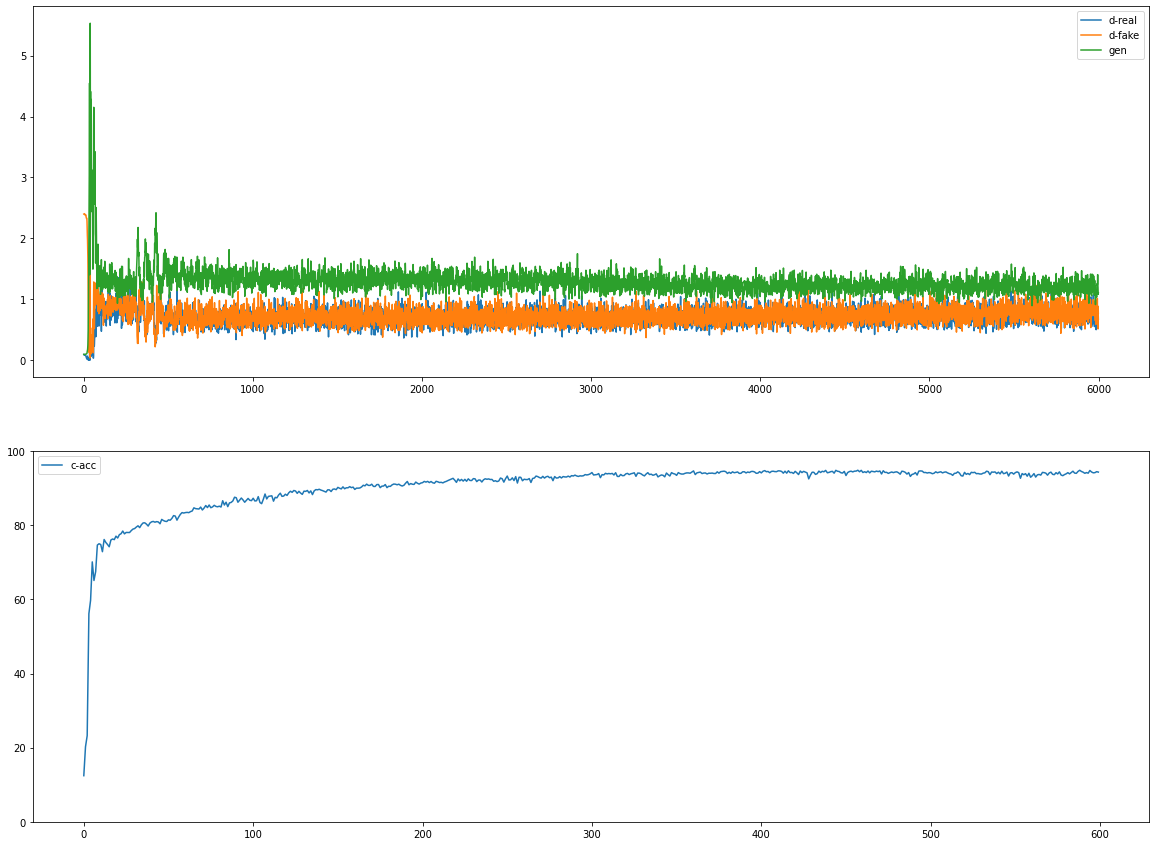

<Figure size 720x576 with 0 Axes>

In [14]:
latent_dim = 100
real_fake, classifier = discriminator()
# Creation du generateur 
g_model = generator(latent_dim)
# Creation du GAN
gan_model = gan(g_model, real_fake)
# On load le dataset
dataset = load_mnist()
# On train model
train(g_model, real_fake, classifier, gan_model, dataset, latent_dim)

In [15]:
#Importation du model
model = load_model('c_model_7200.h5')
# On laod tout le dataset 
(trainX, trainy), (testX, testy) = load_data()
#On augmente la dimention des image pour qui est necessaire pour savoir la nuance de gris sur chaque pixel 
#compris entre [0,255] est qui est indispanesable pour les couche Conv2D
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
# On convertie tout les valeurs de l'image en float 
trainX = trainX.astype('float32')
testX = testX.astype('float32')
# On reduit la valeur des pixel de [0,255] à [-1,1]
trainX = (trainX - 127.5) / 127.5
testX = (testX - 127.5) / 127.5
# On evelue le model sur le Train et le Test
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
print('Train Accuracy: %.3f%%' % (train_acc * 100))
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Test Accuracy: %.3f%%' % (test_acc * 100))

Train Accuracy: 93.767%
Test Accuracy: 94.290%


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ba5e5f6f-8010-4ece-a81c-67a078441286' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>